In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sfm 

#------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------

def cutdata(datas:list,start_date,end_date):
    result = []
    for i in datas:
        mask = (i.index >= start_date) & (i.index <= end_date)
        i=i[mask]
        result.append(i)
    return result

def calidad (ACH):
    if ACH >= 6:
        calidad = 'Ideal'
    elif ACH >= 5 and ACH < 6 :
        calidad = 'Excelente'
    elif ACH >= 4 and ACH < 5:
        calidad = 'Buena'
    elif ACH >= 4 and ACH < 5:
        calidad = 'Mínima'
    elif ACH < 3:
        calidad = 'Baja'
    
    return calidad

def LinearModel(variables,porcentage):
    """
    Parameters:
        - Variables:list -->
        - Porcentage:float  --> 
    

    Returns:
        - RMSE:float --> mean square error
        - coefficients:list --> 
        - Intercept:float  -->  
    """

    Y = variables[0]
    X = pd.DataFrame({str(i):variables[i] for i in range(1,len(variables))})
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = porcentage, random_state=9)
    lin_reg_mod = LinearRegression()
    lin_reg_mod.fit(X_train, y_train)
    pred = lin_reg_mod.predict(X_test)
    test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred)))
    coef = lin_reg_mod.coef_
    intercept = lin_reg_mod.intercept_
    Yc = sum([variables[i] * coef[i-1] for i in range(1,len(variables))] ) + intercept
    return lin_reg_mod.coef_, lin_reg_mod.intercept_ , Yc
    #return Yc
    
def  Merge(datas:list):
    result = pd.DataFrame()
    for i in range(0,len(datas)-1):
        if i == 0:
            result  = pd.merge(datas[i],datas[i+1],left_index=True,right_index=True)
        else:
            result  = pd.merge(result,datas[i+1],left_index=True,right_index=True)
    result = result.dropna()    
    return result

def rolling(y,n):  #Rolling data to smooth values
    rolling = y.rolling(window = n , center = True , min_periods = 1)
    return  rolling.median()

def clean_nan(data,var):
    b = np.array(data[var])
    b = np.where(b == 'out of range',np.nan,b)
    b = np.where(b == 'Calibration',np.nan,b)
    data[var] = list(b)
    return data

#---------------------------------------------------------------------------------------------------



In [9]:
def calibracion (name:list,data_start:int, data_end:int):
    datar = pd.read_csv(name[0])
    data = pd.read_csv(name[1])    
    
    datar.columns = ['Time', 'CO2_ar', 'T', 'H', 'P']
    
    datar.index = pd.DatetimeIndex(datar['Time'], dayfirst = True )
    datar = datar.drop("Time",axis=1)
    datar = clean_nan(datar,'CO2_ar')
    datar.CO2_ar = pd.to_numeric(datar.CO2_ar)
    datar = datar.resample('1T').mean()
    datar.index = datar.index.strftime('%Y-%m-%d %H:%M:%S')
    
    data.index = pd.DatetimeIndex(data.timestamp)# -  pd.Timedelta(minutes = 2)
    data = data.resample('1T').mean()
    data.index = data.index.strftime('%Y-%m-%d %H:%M:%S')
    
    datar, data = cutdata([datar.CO2_ar, data.CO2], data_start, data_end)
    all_data = pd.merge(datar,data,left_index=True,right_index=True)
    all_data.CO2_ar = rolling(all_data.CO2_ar,10)
    all_data.CO2 = rolling(all_data.CO2,10)
    
    #coef , inter, data_cal = LinearModel([all_data.CO2_ar,all_data.CO2],1)
    #all_data['CO2_cal'] = data_cal
    
    
    datar.plot(color = 'k')
    data.plot(color = 'r')
    #data_cal.plot()

    
    return 1 #coef


1

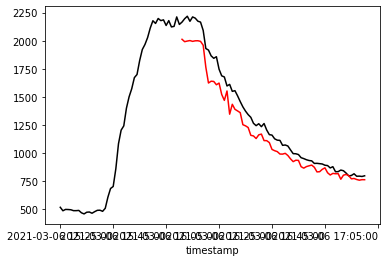

In [10]:
calibracion(['../Datos/aranet1.csv','../Datos/ERIS_SCD30_1.csv'],'2021-03-06 15:25:00','2021-03-06 17:20:00')